<IPython.core.display.Javascript object>


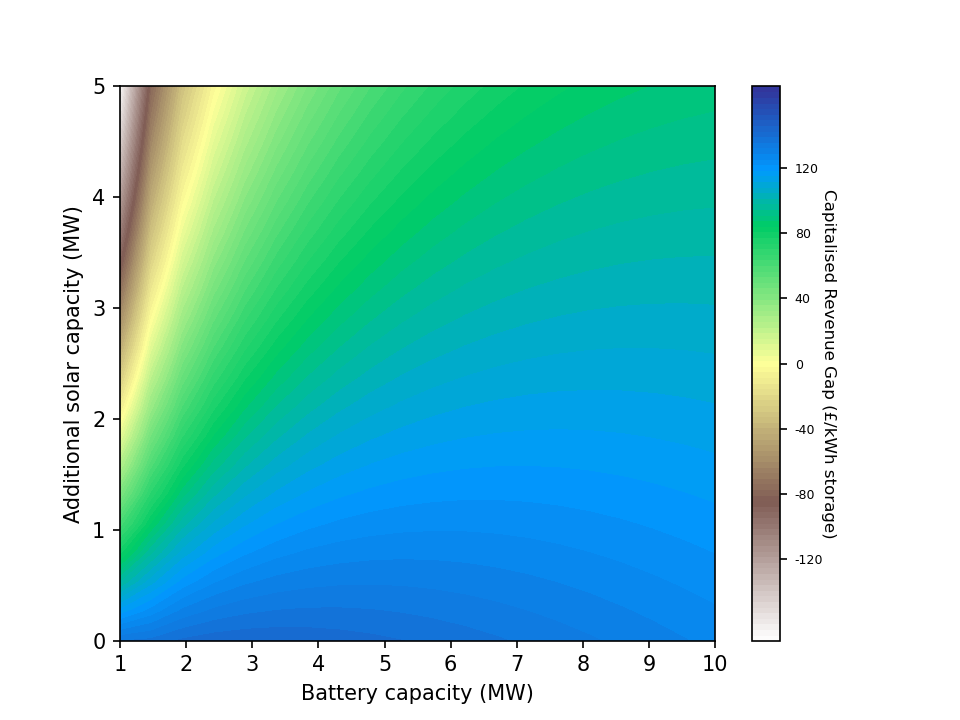

<IPython.core.display.Javascript object>


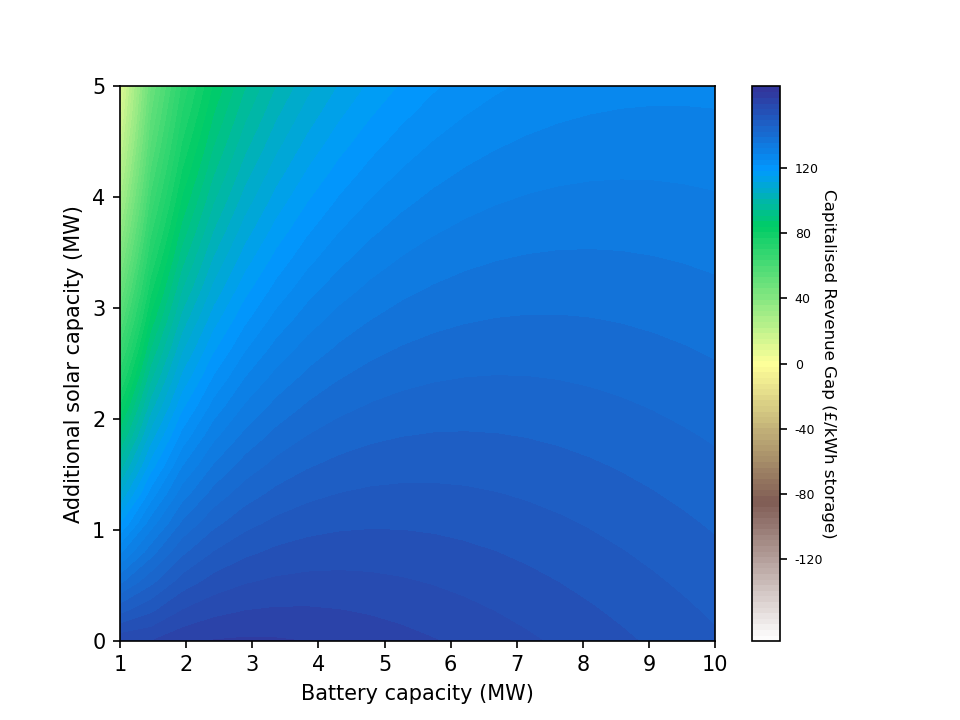

<IPython.core.display.Javascript object>


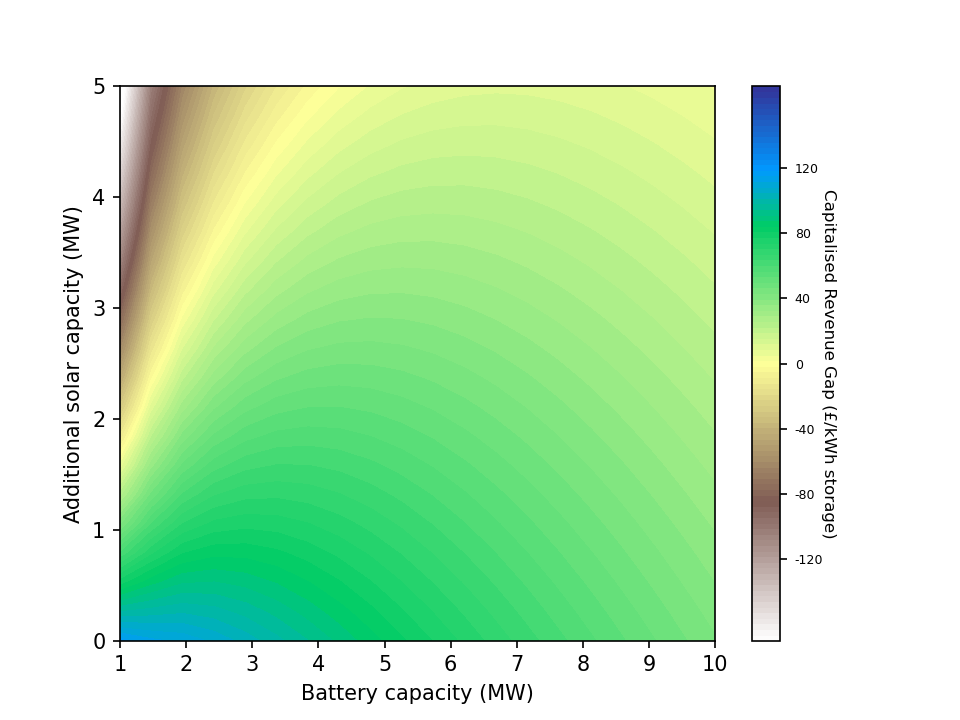

<IPython.core.display.Javascript object>


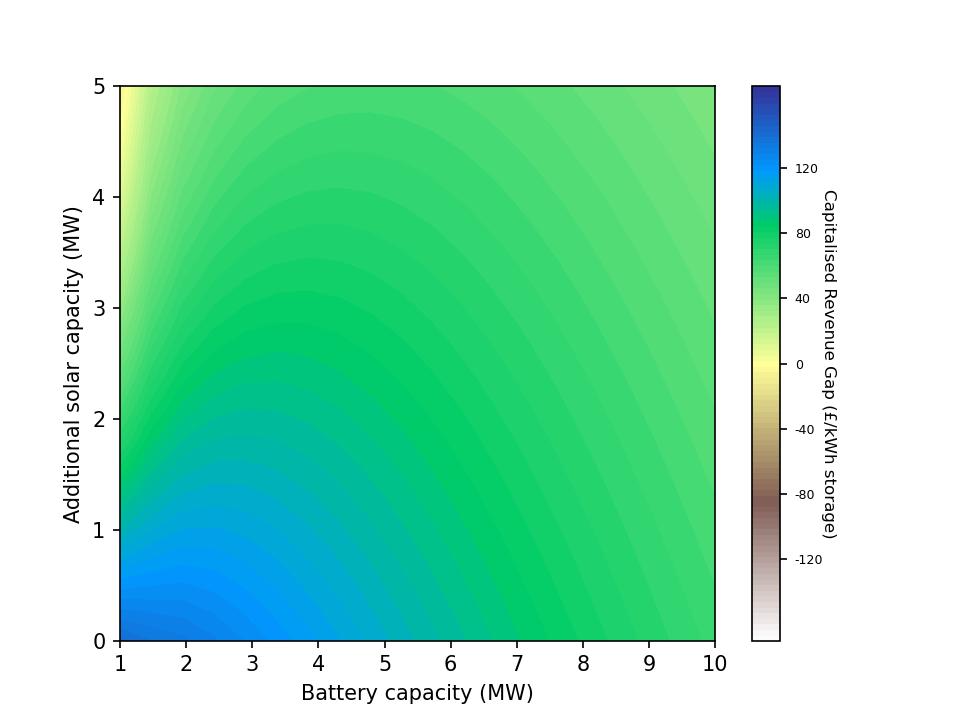

In [2]:
"""This code is using the two lists of variables below as inputs
It gives in output graphs displaying the revenue gap between battery co-location and the BAU scenario
Conclusions drawn from these graphs are summarised in the 'Results' section of the dissertation"""



"""List variables range"""
risk_premium_list=[0,0.02] #Risk premium considered by investors



"""Define all parameters for the model"""
#Import all modules
%matplotlib notebook
import sys 
import math
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
from scipy.optimize import minimize_scalar
import matplotlib as mpl


# Inputs
p_gen_bau=19.2 #MW
gamma=0.108*24*365 #capacity factor
c_ppa=60 #£/MWh
p_substation=15 #MW
l_gen=30 #years
export_capacity=13 #MW
epsilon=0.02 #annual load growth rate at substation

#Fixed parameters
inflation=0.02
wacc_dno=0.0376 #wacc network operators
discount_health=0.015 

# Variable
risk_premium=0 #%

"""Define calculation functions used in the model"""

# Capitalised future revenues 
def capitalised_npv(d,l):
    return (1+d)/d*(1-(1/(1+d)**(l+1)))

# Net present value of cash flow at year i
def npv(d,year):
    return 1/(1+d)**year



"""Parameters for the generation plant"""

opex_gen=0.02 #%CAPEX/year
e_gen_bau= gamma*p_gen_bau
min_daily_e_bau=5 #MWh

# Import csv with generation values for the solar plant in the BAU scenario
renew_prod = pd.read_csv("elec_prod_renewable_ninja.csv")
renew_prod['curtail'] = renew_prod.apply(lambda row: max(row.electricity/1000-export_capacity,0), axis = 1)
energy_curtailed_bau=renew_prod['curtail'].sum()



"""Battery parameters: 4-hour Li-ion batteries"""

l_batt=15 #years
opex_batt=0.025 #% of CAPEX/year
elcc=0.75

#Roundtrip efficiency averaged over the battery's lifetime
efficiency=0.85

# Unit battery cost 
cbatt2020=250 #£/kWh
cbatt2035=130 #£/kWh



"""Network parameters"""

opex_lines=0.02 #% of CAPEX/year
c_nr=30000 #savings local network reinforcement (£/MW/year)

# Number of years of network deferall
def delta_ny(p_batt):
    return math.log(1+p_batt*elcc/p_substation,10)/math.log(1+epsilon,10)

#Curtailment with battery
def energy_curtailed(p_batt,p_gen):
    renew_prod['curtail'] = renew_prod.apply(lambda row: max(row.electricity*p_gen/(p_gen_bau*1000)-export_capacity-p_batt,0), axis = 1)
    return renew_prod['curtail'].sum()

def percent_capacity_peak_shaving(p_batt,p_gen):
    return (energy_curtailed_bau-energy_curtailed(p_batt,p_gen))/(365*4*p_batt)

def percent_curtail(p_batt,p_gen):
    return min(percent_capacity_peak_shaving(p_batt,p_gen),1)


"""--------------------------------------Define all profit functions-------------------------------------------"""



"""Cost of the battery unit"""
def lambda_batt(p_batt):
    return 4*1000*(cbatt2020+cbatt2035*npv(wacc_ep,l_batt))*(1+opex_batt*capitalised_npv(wacc_ep,l_batt))*(1-0.0075*p_batt)
#Present value for battery bought in 2020 and 2035 with economies of scale 



"""Costs of the added PV capacity"""
def c_gen(p_gen):
    return (1233-166*math.log(1+p_gen*1000,10))*1000 #£/MW 
def cost_pv(p_gen):
    return (c_gen(p_gen)*p_gen-c_gen(p_gen_bau)*p_gen_bau)*(1+opex_gen*capitalised_npv(wacc_ep,l_gen))
#Additional CAPEX considering economies of scale



"""Electricity sold not curtailed - Added PV generation"""
def benefit_pv(p_batt,p_gen):
    return gamma*(p_gen-p_gen_bau)*c_ppa*capitalised_npv(wacc_ep,l_gen)*(1-energy_curtailed(p_batt,p_gen)/(p_gen*gamma))
#Electricity sold at BAU PPA price with BAU curtailment



"""Additional costs of the connection the to the grid: import capacity"""
c_mic=40*365 #cost of import capacity, £/MW/year
def import_capacity(p_batt,p_gen):
    if percent_curtail(p_batt,p_gen)<1:
        return max(0,4*p_batt*(1-percent_curtail(p_batt,p_gen))-min_daily_e_bau*p_gen/p_gen_bau)/12*c_mic*capitalised_npv(wacc_ep,l_gen)
    return 0
#Additional import capacity required if the battery does not shave entirely the generation peak



"""Value of the electricity saved from curtailment"""
def lambda_curtailment(p_batt,p_gen):
    return 4*percent_curtail(p_batt,p_gen)*efficiency*365*c_ppa*capitalised_npv(wacc_ep,l_gen)



"""Benefits from the battery participation to flexibility services"""
growth_flex=0.02 #annual increasing value of the revenues from flexibility markets
def lambda_flex_services(p_batt,p_gen):
    if percent_curtail(p_batt,p_gen)<1: 
        return (1-percent_curtail(p_batt,p_gen))*52000*capitalised_npv(wacc_ep-growth_flex,l_gen)
    return 0
#Participation to frequency response markets only authorised if asset capacity > 1MW



"""Benefits from local network reinforcement deferral"""
def lambda_local_network(p_batt,p_gen):
    return c_nr*elcc*(1-percent_curtail(p_batt,p_gen))*capitalised_npv(wacc_dno,delta_ny(p_batt))
#Benefits from substation reinforcement deferral by absorbing growing load



"""Environmental benefits of the electricity saved from curtailment"""
p_CO2=[29,30,31,33,35,43,52,61,72,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85] #£/tCO2
carbon_pvbattery=0.064 #tCO2/MWh
def carbon_grid(year): #carbon content of the grid, tCO2/MWh
    if year<15:
        return 0.2-0.008*year
    return 0.08
def environment(year,p_batt,p_gen): #benefits every year depending on carbon price and grid carbon content
    return 4*percent_curtail(p_batt,p_gen)*efficiency*365*(carbon_grid(year)-carbon_pvbattery)*p_CO2[year]

def lambda_environment(p_batt,p_gen):
    sum=0
    for i in range(0,l_gen):
        sum+=environment(i,p_batt,p_gen)*npv(discount_health,i)
    return sum



"""-------------------------------------------Problem solving-------------------------------------------------"""


"""Define overall profit functions"""
def revenue_gap(x,y): #revenue gap for overall profits (/kWh storage installed)
    return ((import_capacity(x,y)+cost_pv(y)-benefit_pv(x,y))/(4*x)+(lambda_batt(x)-lambda_curtailment(x,y)-lambda_flex_services(x,y)-lambda_local_network(x,y)-lambda_environment(x,y))/4)/1000

def revenue_gap_ep(x,y): #revenue gap for electricity producer (/kWh storage installed)
    return ((import_capacity(x,y)+cost_pv(y)-benefit_pv(x,y))/(4*x)+(lambda_batt(x)-lambda_curtailment(x,y)-lambda_flex_services(x,y))/4)/1000



"""List variables range"""
risk_premium_list=[0,0.02]
local_curtail_list=[0.05,0.1,0.15]
wacc_ep=0.075-inflation+risk_premium



"""Print and download graphs for electricity producers profit"""
for i in risk_premium_list:
    risk_premium=i
    wacc_ep=0.075-inflation+risk_premium
    
    # Creating dataset
    x = np.linspace(1, 10, 20)
    y = np.linspace(p_gen_bau, p_gen_bau+5, 20)
    X, Y = np.meshgrid(x, y)
    vector_revenue_gap_ep = np.vectorize(revenue_gap_ep)
    zs_ep = np.array(vector_revenue_gap_ep(np.ravel(X), np.ravel(Y)))
    Z_ep = zs_ep.reshape(X.shape)
    yg = np.linspace(0, 5, 20)
    X,Yg = np.meshgrid(x,yg)

    vmin, vmax = -170, 170
    levels = np.linspace(vmin,vmax,100)
    fig,ax = plt.subplots()
    surf_ep=ax.contourf(X,Yg,Z_ep,levels=levels, vmax=vmax, vmin=vmin,cmap=cm.terrain_r)
    ax.set_xlabel('Battery capacity (MW)')
    ax.set_ylabel('Additional solar capacity (MW)')
    cbar=fig.colorbar(surf_ep,ax=ax,ticks=[-120,-80,-40,0,40,80,120])
    cbar.ax.set_yticklabels(['-120','-80','-40','0','40','80','120'],fontsize=6)
    cbar.set_label('Capitalised Revenue Gap (£/kWh storage)', rotation=270, fontsize=8,labelpad=6)
    fig.savefig("EP_profit_export_rp"+str(int(i*100)),dpi=2000)

        
        
"""Print and download graphs for overall profit"""
for i in risk_premium_list:
    risk_premium=i
    wacc_ep=0.075-inflation+risk_premium
    
    # Creating dataset
    x = np.linspace(1, 10, 20)
    y = np.linspace(p_gen_bau, p_gen_bau+5, 20)
    vector_revenue_gap = np.vectorize(revenue_gap)
    X, Y = np.meshgrid(x, y)
    zs = np.array(vector_revenue_gap(np.ravel(X), np.ravel(Y)))
    Z = zs.reshape(X.shape)
    yg = np.linspace(0, 5, 20)
    X,Yg = np.meshgrid(x,yg)

    vmin, vmax = -170, 170
    levels = np.linspace(vmin,vmax,100)
    fig,ax = plt.subplots()
    surf=ax.contourf(X,Yg,Z,levels=levels, vmax=vmax, vmin=vmin,cmap=cm.terrain_r)
    ax.set_xlabel('Battery capacity (MW)')
    ax.set_ylabel('Additional solar capacity (MW)')
    cbar=fig.colorbar(surf,ax=ax,ticks=[-120,-80,-40,0,40,80,120])
    cbar.ax.set_yticklabels(['-120','-80','-40','0','40','80','120'],fontsize=6)
    cbar.set_label('Capitalised Revenue Gap (£/kWh storage)', rotation=270, fontsize=8,labelpad=6)
    fig.savefig("export_rp"+str(int(i*100)),dpi=2000)
        